In [46]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set(font_scale=1.5)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import model_selection
import xgboost as xgb


In [47]:
df_train=pd.read_csv(r'train_ctrUa4K.csv')
df_test= pd.read_csv(r'test_lAUu6dG.csv')
                     

In [48]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [49]:
df_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


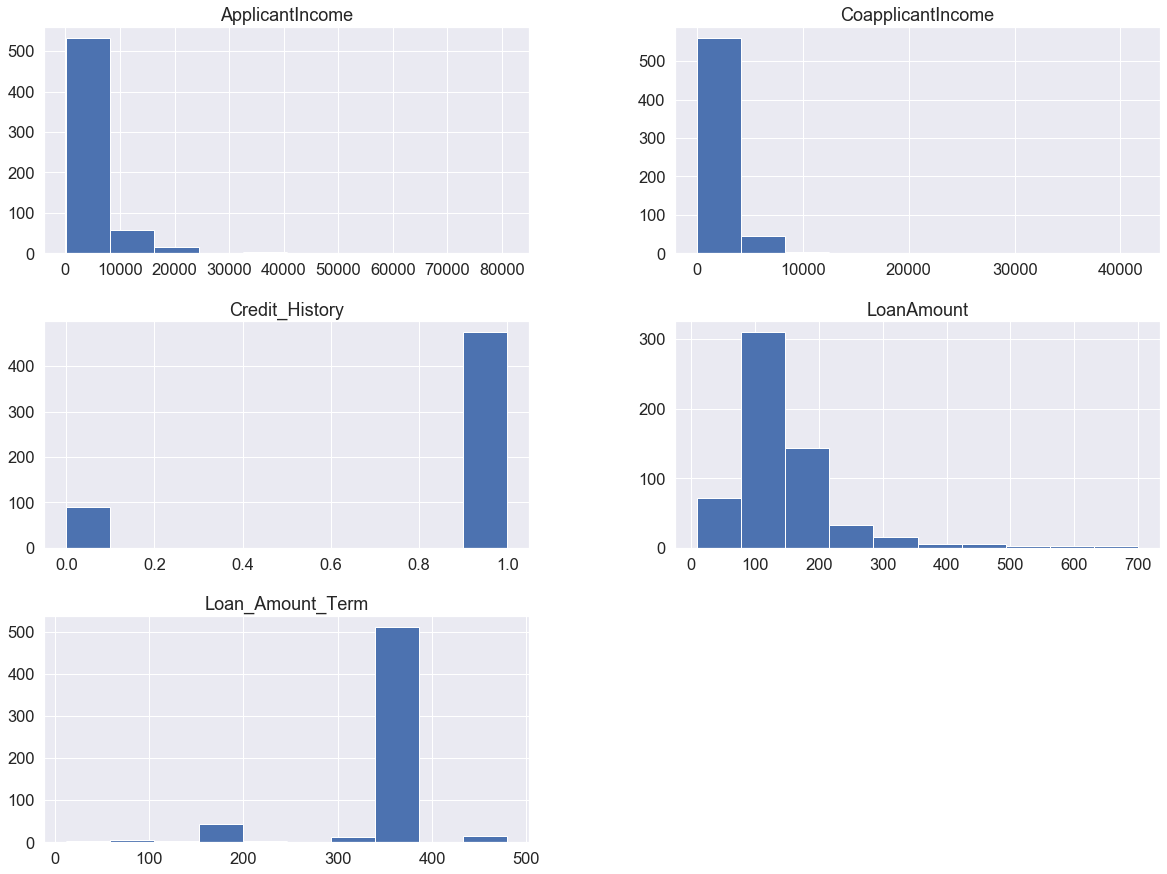

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
df_train.hist(bins=10, figsize=(20,15))
plt.show()


A bunch of outliers, that needs to be taken care of

In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_train, df_train['Loan_Status']):
    strat_train_set = df_train.loc[train_index]
    strat_test_set = df_train.loc[test_index]

In [52]:
strat_test_set['Loan_Status'].value_counts()/ len(strat_test_set)

Y    0.691057
N    0.308943
Name: Loan_Status, dtype: float64

In [53]:
df_train['Loan_Status'].value_counts()/len(df_train)

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

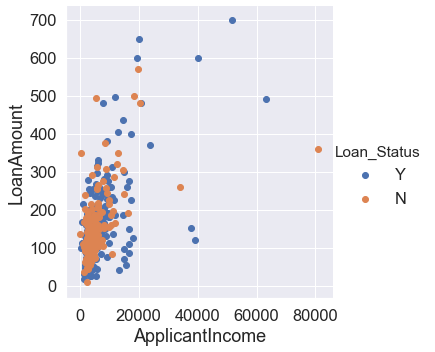

In [54]:
sns.FacetGrid(df_train,hue="Loan_Status",height=5).map(plt.scatter,"ApplicantIncome","LoanAmount").add_legend();
plt.show()

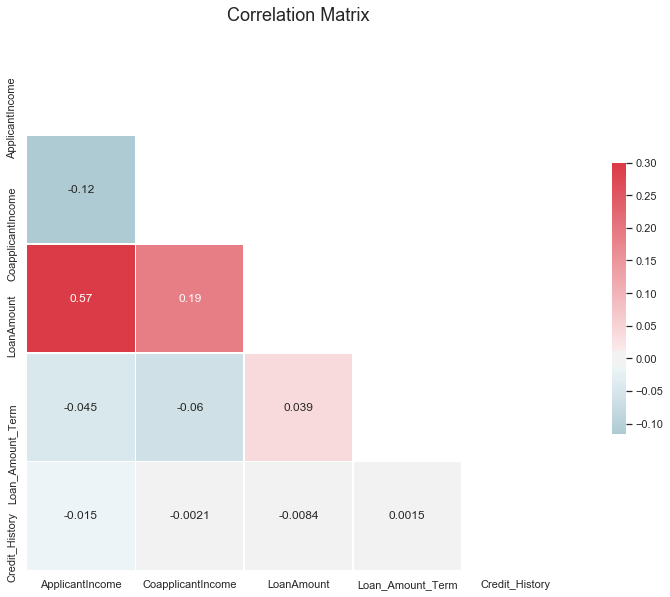

In [55]:
corr=df_train.corr

sns.set(style="white")

corr = df_train.corr()

mask = np.triu(np.ones_like(corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(15, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

In [56]:
df_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E5C3B904C8>,
      dtype=object)

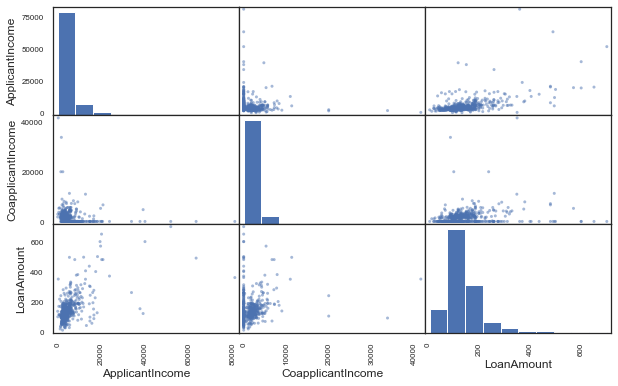

In [57]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',]
scatter_matrix(df_train[attributes], figsize=(10, 6))


In [58]:
strat_train_set.isnull().sum()

Loan_ID               0
Gender               11
Married               3
Dependents            8
Education             0
Self_Employed        27
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           20
Loan_Amount_Term     12
Credit_History       43
Property_Area         0
Loan_Status           0
dtype: int64

In [59]:
strat_train_set.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [60]:
X_train=strat_train_set.drop("Loan_Status",axis=1)
y_train=strat_train_set['Loan_Status'].copy()

In [61]:
df_train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
84.0       4
240.0      4
120.0      3
36.0       2
60.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [62]:
X_train['Loan_Amount_Term_Cat'] = pd.cut(x=X_train['Loan_Amount_Term'], bins=[6,119,239,359,480])

In [63]:
X_train['Loan_Amount_Term_Cat'].value_counts()

(359, 480]    420
(119, 239]     37
(239, 359]     14
(6, 119]        8
Name: Loan_Amount_Term_Cat, dtype: int64

In [64]:
X_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Amount_Term_Cat
154,LP001535,Male,No,0,Graduate,No,3254,0.0,50.0,360.0,1.0,Urban,"(359, 480]"
239,LP001792,Male,Yes,1,Graduate,No,3315,0.0,96.0,360.0,1.0,Semiurban,"(359, 480]"
448,LP002443,Male,Yes,2,Graduate,No,3340,1710.0,150.0,360.0,0.0,Rural,"(359, 480]"
471,LP002517,Male,Yes,1,Not Graduate,No,2653,1500.0,113.0,180.0,0.0,Rural,"(119, 239]"
273,LP001894,Male,Yes,0,Graduate,No,2620,2223.0,150.0,360.0,1.0,Semiurban,"(359, 480]"


In [65]:
X_train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area',
       'Loan_Amount_Term_Cat'],
      dtype='object')

In [66]:
X_train_Num = X_train[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]
X_train_Cat = X_train[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History', 'Property_Area',
       'Loan_Amount_Term_Cat']]

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

X_train_Num_tr = num_pipeline.fit_transform(X_train_Num)

In [68]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder(sparse=False)

Cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder(sparse=False)),
     ])
X_train_cat_tr = Cat_pipeline.fit_transform(X_train_Cat)

In [69]:
from sklearn.compose import ColumnTransformer

num_attribs = list(X_train_Num)
cat_attribs = list(X_train_Cat)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", Cat_pipeline, cat_attribs),
    ])

X_train_prepared = full_pipeline.fit_transform(X_train)

In [70]:
X_train_prepared.shape

(491, 24)

In [71]:
y_train.replace(["Y","N"],[1,0],inplace=True)

In [72]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train_prepared, y_train)


RandomForestClassifier(random_state=42)

In [73]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
p1=forest_clf.predict(X_train_prepared)
print(confusion_matrix(y_train,p1))
print("Accuracy Score {}".format(accuracy_score(y_train,p1)))
print("Classification report: {}".format(classification_report(y_train,p1)))

[[154   0]
 [  0 337]]
Accuracy Score 1.0
Classification report:               precision    recall  f1-score   support

           0       1.00      1.00      1.00       154
           1       1.00      1.00      1.00       337

    accuracy                           1.00       491
   macro avg       1.00      1.00      1.00       491
weighted avg       1.00      1.00      1.00       491



## Preparing Test Data

In [74]:
X_test=strat_test_set.drop("Loan_Status",axis=1)
y_test=strat_test_set['Loan_Status'].copy()

In [75]:
X_test['Loan_Amount_Term_Cat'] = pd.cut(x=X_test['Loan_Amount_Term'], bins=[6,119,239,359,480])

In [76]:
X_test_Num = X_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]
X_test_Cat = X_test[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History', 'Property_Area',
       'Loan_Amount_Term_Cat']]

In [77]:
num_pipeline2 = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

X_test_Num_tr = num_pipeline2.fit_transform(X_test_Num)

In [78]:
Cat_pipeline2 = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder(sparse=False)),
     ])
X_test_cat_tr = Cat_pipeline2.fit_transform(X_test_Cat)

In [79]:
num_attribs2 = list(X_test_Num)
cat_attribs2 = list(X_test_Cat)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline2, num_attribs2),
        ("cat", Cat_pipeline2, cat_attribs2),
    ])

X_test_prepared = full_pipeline.fit_transform(X_test)

In [80]:
X_test_prepared.shape

(123, 24)

In [81]:
X_test.shape

(123, 13)

In [82]:
y_test.replace(["Y","N"],[1,0],inplace=True)

_____________________________________________________________________________________________

In [83]:
p2=forest_clf.predict(X_test_prepared)
print(confusion_matrix(y_test,p2))
print("Accuracy Score {}".format(accuracy_score(y_test,p2)))
print("Classification report: {}".format(classification_report(y_test,p2)))

[[22 16]
 [ 8 77]]
Accuracy Score 0.8048780487804879
Classification report:               precision    recall  f1-score   support

           0       0.73      0.58      0.65        38
           1       0.83      0.91      0.87        85

    accuracy                           0.80       123
   macro avg       0.78      0.74      0.76       123
weighted avg       0.80      0.80      0.80       123



## Randomized SearchCV

In [84]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8], 'criterion': ['entropy', 'gini']}


In [86]:
rf=RandomForestClassifier()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid,n_iter=100,cv=3,verbose=2,
                               random_state=100,n_jobs=-1)
### fit the randomized model
rf_randomcv.fit(X_train_prepared,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 120, 230, 340, 450,
                                                      560, 670, 780, 890,
                                                      1000],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [2, 5, 10, 14],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=100, verbose=2)

In [87]:
rf_randomcv.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 120,
 'criterion': 'gini'}

In [88]:
rf_randomcv.best_estimator_

RandomForestClassifier(max_depth=120, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=5, n_estimators=1400)

In [89]:
best_random_grid=rf_randomcv.best_estimator_

In [90]:
p3=best_random_grid.predict(X_test_prepared)
print(confusion_matrix(y_test,p3))
print("Accuracy Score {}".format(accuracy_score(y_test,p3)))
print("Classification report: {}".format(classification_report(y_test,p3)))

[[21 17]
 [ 1 84]]
Accuracy Score 0.8536585365853658
Classification report:               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



#### we see an increase of 5% in the accuracy! lets take a range of best params and fetch it in GridSearch CV and lets see if it helps

In [92]:
rf_randomcv.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 120,
 'criterion': 'gini'}

## GridSearch CV

In [93]:
## Defining  a range around the best parameters from the Random Search CV
from sklearn.model_selection import GridSearchCV

param_grid1 = {
    'criterion': [rf_randomcv.best_params_['criterion']],
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+2, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 4],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 2,
                          rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 200, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] + 100, rf_randomcv.best_params_['n_estimators'] + 200]
}

print(param_grid1)

{'criterion': ['gini'], 'max_depth': [120], 'max_features': ['sqrt'], 'min_samples_leaf': [6, 8, 10], 'min_samples_split': [3, 4, 5, 6, 7], 'n_estimators': [1200, 1300, 1400, 1500, 1600]}


In [94]:
rfc=RandomForestClassifier()
grid_search=GridSearchCV(estimator=rfc,param_grid=param_grid1,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(X_train_prepared,y_train)

Fitting 10 folds for each of 75 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed: 19.6min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [120],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [6, 8, 10],
                         'min_samples_split': [3, 4, 5, 6, 7],
                         'n_estimators': [1200, 1300, 1400, 1500, 1600]},
             verbose=2)

In [98]:
best_grid=grid_search.best_estimator_

In [99]:
p4=best_grid.predict(X_test_prepared)
print(confusion_matrix(y_test,p4))
print("Accuracy Score {}".format(accuracy_score(y_test,p4)))
print("Classification report: {}".format(classification_report(y_test,p4)))

[[21 17]
 [ 1 84]]
Accuracy Score 0.8536585365853658
Classification report:               precision    recall  f1-score   support

           0       0.95      0.55      0.70        38
           1       0.83      0.99      0.90        85

    accuracy                           0.85       123
   macro avg       0.89      0.77      0.80       123
weighted avg       0.87      0.85      0.84       123



## Preparing the Unseen Test Data

In [102]:
df_test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [103]:
df_test['Loan_Amount_Term_Cat'] = pd.cut(x=df_test['Loan_Amount_Term'], bins=[6,119,239,359,480])

df_test_Num = df_test[['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']]
df_test_Cat = df_test[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed','Credit_History', 'Property_Area',
       'Loan_Amount_Term_Cat']]

num_pipeline3 = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

df_test_Num_tr = num_pipeline3.fit_transform(df_test_Num)

Cat_pipeline3 = Pipeline([
        ('imputer', SimpleImputer(strategy="most_frequent")),
        ('cat_encoder', OneHotEncoder(sparse=False)),
     ])
df_test_cat_tr = Cat_pipeline3.fit_transform(df_test_Cat)

num_attribs3 = list(df_test_Num)
cat_attribs3 = list(df_test_Cat)
full_pipeline = ColumnTransformer([
        ("num", num_pipeline3, num_attribs3),
        ("cat", Cat_pipeline3, cat_attribs3),
    ])

df_test_prepared = full_pipeline.fit_transform(df_test)

df_test_prepared.shape


(367, 24)

In [104]:
df_test.shape

(367, 13)

In [105]:
Predy=best_grid.predict(df_test_prepared)

In [108]:
df_predy=pd.DataFrame(Predy)
df_predy.replace([0,1],['N','Y'],inplace=True)

In [110]:
df_predy.head(5)

,0
0,Y
1,Y
2,Y
3,Y
4,Y


In [120]:
df_predy=df_predy.rename(columns={0:"Loan_Status"})

In [121]:
df_predy

,Loan_Status
0,Y
1,Y
2,Y
3,Y
4,Y
...,...
362,Y
363,Y
364,Y
365,Y


In [113]:
Submf=pd.read_csv(r'sample_submission_49d68Cx.csv')

In [114]:
Submf.columns

Index(['Loan_ID', 'Loan_Status'], dtype='object')

In [122]:
df_att1=pd.concat([Submf['Loan_ID'],df_predy["Loan_Status"]],axis=1)

In [123]:
df_att1.head(4)

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y


In [124]:
df_att1.to_csv("LPred1.csv",index=False)

In [125]:
import pickle
# open a file, where you ant to store the data
file = open('RFbestGridLat.pkl', 'wb')

# dump information to that file
pickle.dump(best_grid, file)